### Import Library 

In [108]:
from dataloader import read_bci_data
import argparse
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from functools import reduce
from IPython.display import clear_output

### DataSet

In [109]:
def gen_dataset(train_x, train_y, test_x, test_y):
    datasets = []
    for x, y in [(train_x, train_y), (test_x, test_y)]:
        x = torch.stack(
            [torch.Tensor(x[i]) for i in range(x.shape[0])]
        )
        y = torch.stack(
            [torch.Tensor(y[i:i+1]) for i in range(y.shape[0])]
        )
        datasets += [TensorDataset(x, y)]
        
    return datasets

### EEGNet

In [110]:
class EEGNet(nn.Module):
    def __init__(self, activation=nn.ReLU):
        super().__init__()
        self.firstconv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 51), stride=(1,1), padding=(0,25), bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2,1), stride=(1,1), groups=16, bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            activation(),
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0),
            nn.Dropout(p=0.25)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            activation(),
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0),
            nn.Dropout(p=0.25)
        )
        self.classify = nn.Sequential(
            nn.Linear(in_features=736, out_features=2, bias=True)
        )

    def forward(self, x):
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = x.view(-1, self.classify[0].in_features)
        x = self.classify(x)
        return x

### DeepConvNet

In [111]:
class DeepConvNet(nn.Module):
    def __init__(self, activation=nn.ReLU):
        super().__init__()
        self.deepconv = [25, 50, 100, 200]
        self.conv0 = nn.Sequential(
            nn.Conv2d(1, 25, kernel_size=(1, 5), stride=(1, 1), padding=(0, 0), bias=True),
            nn.Conv2d(25, 25, kernel_size=(2, 1), stride=(1, 1), padding=(0, 0), bias=True),
            nn.BatchNorm2d(25),
            activation(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5)
        )

        for idx in range(1, len(self.deepconv)):
            setattr(self, 'conv'+str(idx), nn.Sequential(
                nn.Conv2d(self.deepconv[idx-1], self.deepconv[idx], kernel_size=(1,5), stride=(1,1), padding=(0,0), bias=True),
                nn.BatchNorm2d(self.deepconv[idx]),
                activation(),
                nn.MaxPool2d(kernel_size=(1, 2)),
                nn.Dropout(p=0.5)
            ))
        
        flatten_size =  self.deepconv[-1] * reduce(lambda x,_: round((x-4)/2), self.deepconv, 750)
        self.classify = nn.Sequential(nn.Linear(flatten_size, 2, bias=True))

    def forward(self, x):
        for i in range(len(self.deepconv)):
            x = getattr(self, 'conv'+str(i))(x)
        x = x.view(-1, self.classify[0].in_features)
        x = self.classify(x)
        return x

### Setting Model with Different Activation

In [112]:
def setting_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # setting model with three activation
    models_EEG = {
        "LeakyReLU": EEGNet(nn.LeakyReLU).to(device),
        "ReLU": EEGNet(nn.ReLU).to(device),
        "ELU": EEGNet(nn.ELU).to(device)
    }
    models_DCN = {
        "LeakyReLU": DeepConvNet(nn.LeakyReLU).to(device),
        "ReLU": DeepConvNet(nn.ReLU).to(device),
        "ELU": DeepConvNet(nn.ELU).to(device)
    }
    return models_EEG, models_DCN

### Plot Accuracy

In [113]:
def plot_accuracy(model_name, **kwargs):
    # fix image size
    fig = plt.figure(figsize=(10, 6))
    plt.title(f"Activation function comparsion({model_name})")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy(%)')
    # plot accuracy
    for label, data in kwargs.items():
        plt.plot(
            range(1, len(data)+1), data, 
            '--' if 'test' in label else '-', 
            label=label
        )
    # plot legend box
    plt.legend(
        loc='lower right',
        fancybox=True, shadow=True
    )

    plt.show()
    
    return fig

### Training and Testing Model

In [114]:
def run(models, opts, model_name):
    train_loader = DataLoader(train_dataset, batch_size=opts.batch_size)
    test_loader = DataLoader(test_dataset, len(test_dataset))

    accuracy = {}
    for key in models:
        accuracy[key+"_train"] = []
        accuracy[key+"_test"] = []
    
    optimizers = {
        key: opts.optimizer(value.parameters(), lr=opts.learning_rate) 
        for key, value in models.items()
    }

    for _ in range(opts.epochs):
        train_correct = {key:0.0 for key in models}
        test_correct = {key:0.0 for key in models}

        # train
        for model in models.values():
            model.train()

        # update parameters of our training
        for _, (x, y) in enumerate(train_loader):
            inputs = x.to(device)
            labels = y.to(device).long().view(-1)

            # clear previous gradient
            for optimizer in optimizers.values():
                optimizer.zero_grad()
            for key, model in models.items():
                outputs = model(inputs) # forward propagation
                loss = opts.loss_function(outputs, labels) # loss calculate
                loss.backward() # back propagation to calculate gradient
                train_correct[key] += (torch.max(outputs, dim=1)[1] == labels).sum().item()
            # gradient descent
            for optimizer in optimizers.values():
                optimizer.step()

        # test
        for model in models.values():
            model.train()

        with torch.no_grad():
            for _, (x, y) in enumerate(test_loader):
                inputs = x.to(device)
                labels = y.to(device).long().view(-1)
               
                for key, model in models.items():
                    outputs = model(inputs)
                    test_correct[key] += (torch.max(outputs, dim=1)[1] == labels).sum().item()

        for key, value in train_correct.items():
            accuracy[key+"_train"] += [(value*100.0) / len(train_dataset)]
    
        for key, value in test_correct.items():
            accuracy[key+"_test"] += [(value*100.0) / len(test_dataset)]
        
        # plot on each epoch
        clear_output(wait=True)
        plot_accuracy(model_name, **accuracy)

In [116]:
parser = argparse.ArgumentParser()

parser.add_argument('--batch_size', type=int, default=64, help='Default batch size is 64')
parser.add_argument('--learning_rate', type=float, default=1e-2, help='Default learning rate is 1e-2')
parser.add_argument('--epochs', type=int, default=300, help='Default epochs is 300')
parser.add_argument('--optimizer', type=type, default=optim.Adam, help='Default optimizer is Adam')
parser.add_argument('--loss_function', type=type, default=nn.CrossEntropyLoss(), help='Default loss function is CrossEntropyLoss')

opts = parser.parse_args([])

train_dataset, test_dataset = gen_dataset(*read_bci_data())
models_EEG, models_DCN = setting_model()

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)


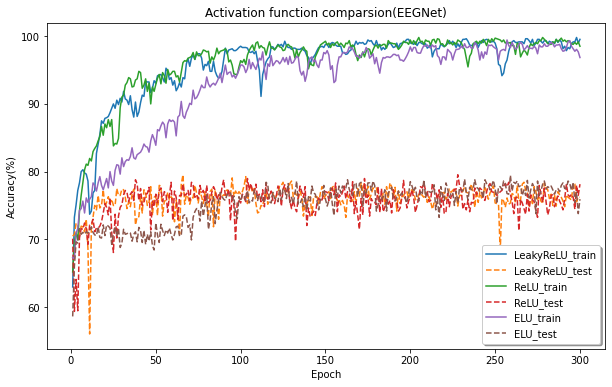

In [118]:
run(models_EEG, opts, 'EEGNet')

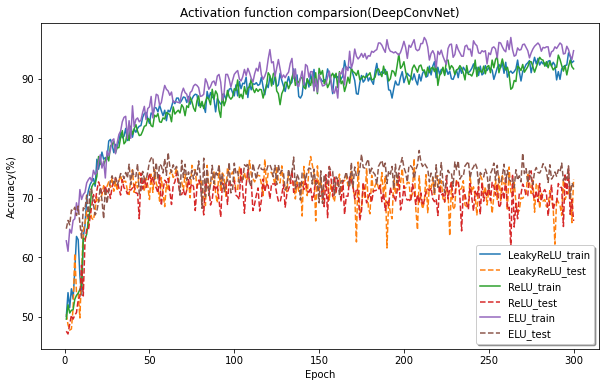

In [117]:
run(models_DCN, opts, 'DeepConvNet')

### Report

根據作業要求我首先實做了兩個網路並連上三個activation
在EEGNet中我寫的較順利，只有最後classify前忘了要把資料resize所以卡了一下。
在DeepConvNet中我發現了比較多的問題，其中一個就是我寫出來的結果他的網路參數數跟lab要求的有點差，但我基本上是按照要求刻的，到最後都沒找到問題原因。第二個問題大概就是我想把所有layer用一個for寫出來，但後來發生了太多問題了，所以最後只好作罷。

在寫training和testing中，因為本次作業沒規定是要跑幾次model update一次，我就每跑一次就去進行gradient decent並update model的參數了，並把每一個epoch跑出的結果丟入畫圖的function，去把每一次的結果畫出來，這邊查了一下要怎麼洗掉過去畫圖的結果，這樣程式跑完就只會有兩張圖。

結果顯示在EEGNet中，LeakyReLU和ReLU會有較好的accuracy，而在DeepConvNet中則是ELU有較好的結果。